# Лабораторные работы по дисциплине "Методы, средства и технологии мультимедиа"

**Выполнила студентка гр. М8О-406Б-21 Волошинская Евгения Владимировна**

В качестве данных я выбрала датасет Loan Approval Classification Dataset (https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data). Эти данные могут быть использованы для обучения моделей ИИ, которые автоматизируют процесс одобрения кредитов, оценивают кредитный риск, выявляют важные факторы при принятии решений, обнаруживают потенциальное мошенничество и персонализируют кредитные предложения. Это помогает финансовым учреждениям повысить эффективность, уменьшить ручную работу, принимать более обоснованные решения при обработке кредитных заявок и улучшать клиентский опыт.

Данные подходят как для задачи классификации, так и для регрессии.

Для задачи классификации: т.к. классы не сбалансированы, то основные метрики качества для сравнения моделей - Precision, Recall, F1-мера, но также рассчитаны и точность, и матрица ошибок, полнота и AUC.

Для задачи регрессии:

## Лабораторная работа №1: Проведение исследований с алгоритмом KNN

### Исследование данных

Импортируем необходимые библиотеки:

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings("ignore")

Импортируем данные и проведем их анализ:

In [ ]:
df = pd.read_csv("loan_data.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [ ]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


Посмотрим, какие значения категориальных полей есть, и их распределение:

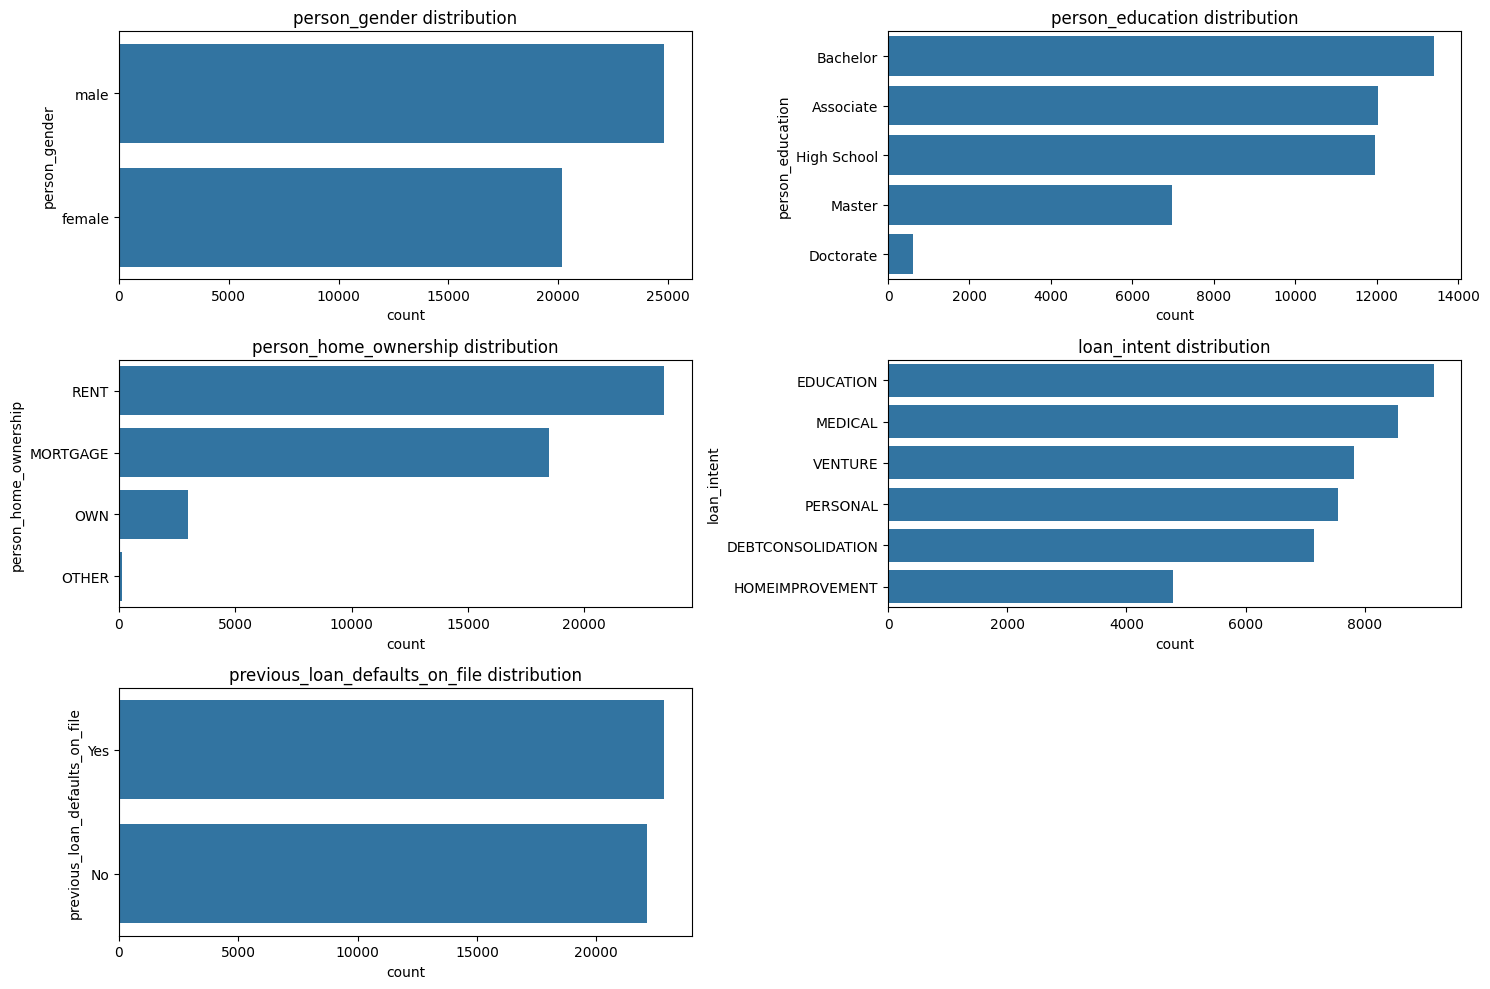

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_distribution = {col: df[col].value_counts() for col in categorical_cols}
#print(categorical_cols)

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f"{col} distribution")
    plt.tight_layout()
plt.show()

Возможные гипотезы для улучшения бейзлайнов:
- нужно убрать нулевые и дублирующиеся данные
- можно убрать кореллирующие данные (чтобы они не усиливали друг друга и не давали отклонения)
- использовать точные методы кодирования категориальных данных - one-hot encoding
- нормализовать данные: применить масштабирование StandartScaler ко входным данным
- увеличить или изменить гиперпараметры (например, число k "соседей")




- можно привести 3 столбца, отвечающие за дату, к единому числу. Благодаря этому, дата выхода станет единым аспектом, а не тремя, к тому же можно будет однозначно сказать, какая дата "больше".
- title и url, скорее всего, не играют никакой роли, к тому же численно не представимы.

### KNN-классификация

#### Baseline

Препроцессинг данных:

In [ ]:
# One Hot Encoding
df = pd.get_dummies(df, drop_first=True)
df.head(3)

#for col in df.select_dtypes('object').columns:
#  df[col] = OrdinalEncoder().fit_transform(df[[col]])

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_gender_male,...,person_education_Master,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes
0,22.0,71948.0,0,35000.0,16.02,0.49,3.0,561,1,False,...,True,False,False,True,False,False,False,True,False,False
1,21.0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,False,...,False,False,True,False,True,False,False,False,False,True
2,25.0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,False,...,False,False,False,False,False,False,True,False,False,False


Разбиваем данные на тренировочную и тестовую выборки:

In [ ]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Задаем модель и классифицируем:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

Оцениваем модель по метрикам:

Accuracy : 83.53333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     10500
           1       0.72      0.42      0.53      3000

    accuracy                           0.84     13500
   macro avg       0.79      0.69      0.72     13500
weighted avg       0.82      0.84      0.82     13500



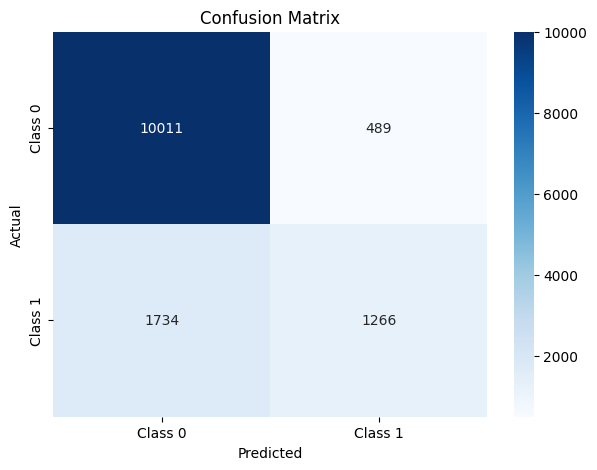

In [ ]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy : {acc * 100}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Cal confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Draw confusion matrix
# Loan approval status: 1 = approved; 0 = rejected
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])

0.8054175714285713

#### Улучшение бейзлайна

Гипотеза 1. Наличие нулевых значений, дубликатов:

In [ ]:
print(f"Null Value:\n{df.isnull().sum()}")

Null Value:
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


In [ ]:
print(f"Duplicate Value: {df.duplicated().sum()}")

Duplicate Value: 0


Гипотеза 2. Распределение целевой переменной (классы несбалансированные)

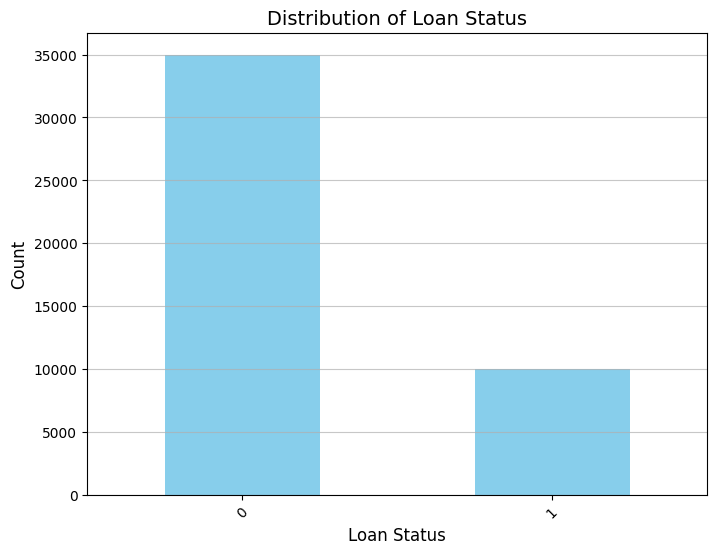

In [ ]:
value_counts = df['loan_status'].value_counts()

plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Loan Status', fontsize=14)
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.7)
plt.show()

Гипотеза 3. Неоптимальные гиперпараметры

Подберем гиперпараметр k:

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': range(10, 30)}
grid_clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1_weighted')
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(10, 30)}, scoring='f1_weighted')

In [ ]:
best_knn_clf = grid_clf.best_estimator_
y_pred = best_knn_clf.predict(X_test)

Визуализируем результат:

Accuracy : 83.54074074074074
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     10500
           1       0.68      0.48      0.57      3000

    accuracy                           0.84     13500
   macro avg       0.77      0.71      0.73     13500
weighted avg       0.82      0.84      0.82     13500



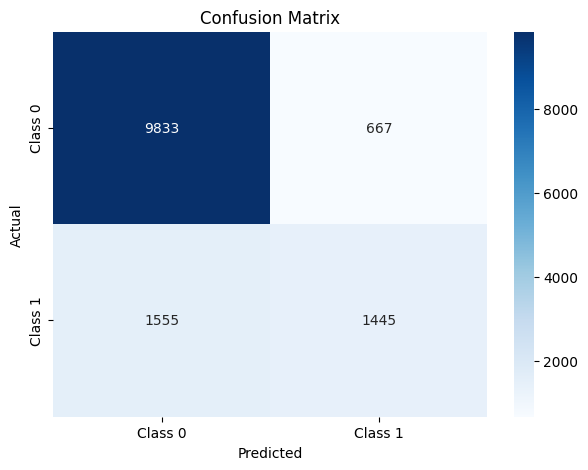

In [ ]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy : {acc * 100}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Cal confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Draw confusion matrix
# Loan approval status: 1 = approved; 0 = rejected
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
roc_auc_score(y_test, grid_clf.predict_proba(X_test)[:,1])

0.835731253968254

#### Вывод:
Видим небольшое улучшение с увеличением значения гиперпараметра k на несколько единиц, однако при k ~ 30 результат снова ухудшается. В целом, данная модель имеет достаточную точность для предсказания класса 0 (кредит не одобрен), и низкую для класса 1 (кредит одобрен).

### KNN-регрессия

####Baseline

In [ ]:
df = pd.read_csv("loan_data.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Преобразуем категориальные переменные в числовые путем One-Hot encoding

In [ ]:
df_filtered = pd.get_dummies(df, drop_first=True)

In [ ]:
# Разделяем независимые переменные и искомую
target = 'loan_int_rate'
X = df_filtered.drop(columns=[target])
y = df_filtered[target]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error (%): {mape}')
print(f'R² Score: {r2}')

Mean Squared Error: 9.655816674999999
Mean Absolute Error: 2.4697092592592598
Mean Absolute Percentage Error (%): 0.24785465602610565
R² Score: -0.09853641496225762


#### Улучшение baseline

Гипотеза 1. Препроцессинг данных: необходима нормализация данных

In [23]:
# Нормализуем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [25]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [26]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error (%): {mape}')
print(f'R² Score: {r2}')

Mean Squared Error: 9.24950637175926
Mean Absolute Error: 2.442762037037037
Mean Absolute Percentage Error (%): 0.24538693184273516
R² Score: -0.05231073784890161


Гипотеза 2. Неоптимальные гиперпараметры: необходимо подобрать иное значение k

In [30]:
param_grid = {'n_neighbors': range(5, 45)}
grid_reg = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(5, 45)}, scoring='r2')

In [31]:
print(grid_reg.best_estimator_)
best_knn_reg = grid_reg.best_estimator_
y_pred = best_knn_reg.predict(X_test)

KNeighborsRegressor(n_neighbors=43)


In [32]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error (%): {mape}')
print(f'R² Score: {r2}')

Mean Squared Error: 7.641246370486549
Mean Absolute Error: 2.247441670973299
Mean Absolute Percentage Error (%): 0.22784069570821522
R² Score: 0.1306600284353826


####Вывод:
Аналогично KNN модели классификации, изменение гиперпараметра k дает некоторое небольшое улучшение точности для KNN модели регрессии. Нормализация числовых данных также дает незначительное улучшение.

###Самостоятельная имплементация

####Классификация

In [ ]:
df = pd.get_dummies(df, drop_first=True)
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [ ]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552452 sha256=bb648247816ac9e6c8eb9826844b73943b5ab9a82cad1e0e328e46fb5376a632
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [ ]:
from collections import Counter
from annoy import AnnoyIndex

class MyKNNClassifier:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.n_trees = 10

    def fit(self, features, target):
        self.train_features= np.array(features)
        self.train_target = np.array(target)
        self.n_features = self.train_features.shape[1]

        self.index = AnnoyIndex(self.n_features)
        for i, x in enumerate(self.train_features):
            self.index.add_item(i, x)

        self.index.build(self.n_trees)


    def predict(self, features):
        features = np.array(features)
        predictions = []
        for x in features:
            nearest_indices = self.index.get_nns_by_vector(x, self.n_neighbors)

            nearest_labels = self.train_target[nearest_indices]

            most_common_class = Counter(nearest_labels).most_common(1)[0][0]
            predictions.append(most_common_class)

        return np.array(predictions)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

my_knn = MyKNNClassifier(n_neighbors=4)
my_knn.fit(X_train, y_train)

y_pred = my_knn.predict(X_test)

ROC AUC: 0.835731253968254
Accuracy : 80.65185185185186
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     10500
           1       0.58      0.45      0.51      3000

    accuracy                           0.81     13500
   macro avg       0.72      0.68      0.69     13500
weighted avg       0.79      0.81      0.80     13500



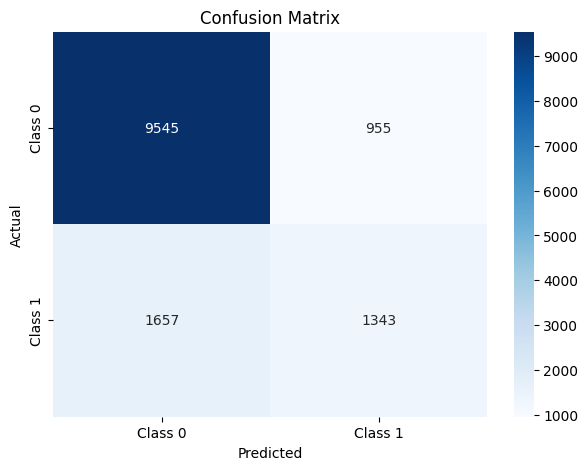

In [ ]:
print("ROC AUC:", roc_auc_score(y_test, grid_clf.predict_proba(X_test)[:,1]))

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy : {acc * 100}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Cal confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Draw confusion matrix
# Loan approval status: 1 = approved; 0 = rejected
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Улучшенный бейзлайн:

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

my_knn = MyKNNClassifier(n_neighbors=grid_clf.best_params_['n_neighbors'])
my_knn.fit(X_train, y_train)

ROC AUC: 0.5
Accuracy : 80.65185185185186
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     10500
           1       0.58      0.45      0.51      3000

    accuracy                           0.81     13500
   macro avg       0.72      0.68      0.69     13500
weighted avg       0.79      0.81      0.80     13500



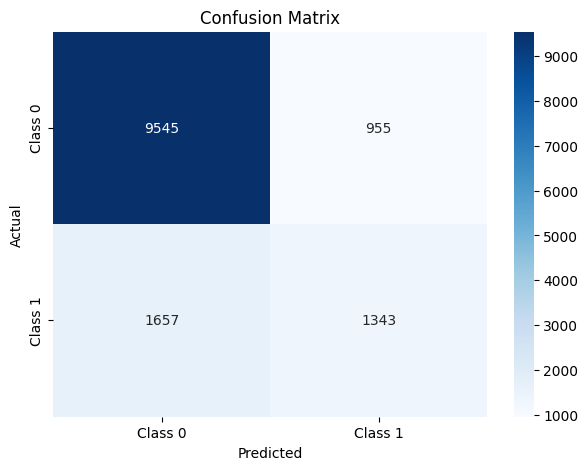

In [ ]:
print("ROC AUC:", roc_auc_score(y_test, grid_clf.predict_proba(X_test)[:,1]))

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy : {acc * 100}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Cal confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Draw confusion matrix
# Loan approval status: 1 = approved; 0 = rejected
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Регрессия

In [21]:
class MyKNNRegressor:
    def __init__(self, n_neighbors=4):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        # Преобразуем X и y в numpy массивы с явным указанием типа float
        self.X_train = X.values.astype(float) if isinstance(X, pd.DataFrame) else X.astype(float)
        self.y_train = y.values.astype(float) if isinstance(y, pd.Series) else y.astype(float)

    def predict(self, X):
        # Преобразуем X в numpy массив с явным указанием типа float
        X = X.values.astype(float) if isinstance(X, pd.DataFrame) else X.astype(float)
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        # Проверяем, что x имеет тип float
        x = x.astype(float)
        # Вычисляем расстояния
        distances = np.linalg.norm(self.X_train - x, axis=1)
        # Находим индексы k ближайших соседей
        k_indices = np.argsort(distances)[:self.n_neighbors]
        # Получаем значения целевой переменной для k ближайших соседей
        k_nearest_values = self.y_train[k_indices]
        # Возвращаем среднее значение
        return np.mean(k_nearest_values)

In [8]:
df = pd.read_csv("loan_data.csv")
df_filtered = pd.get_dummies(df, drop_first=True)
target = 'loan_int_rate'
X = df_filtered.drop(columns=[target])
y = df_filtered[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
my_knn_r = MyKNNRegressor()
my_knn_r.fit(X_train, y_train)

y_pred = my_knn_r.predict(X_test)

In [20]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error (%): {mape}')
print(f'R² Score: {r2}')

Mean Squared Error: 9.65630852685185
Mean Absolute Error: 2.4697685185185185
Mean Absolute Percentage Error (%): 0.24785889488585236
R² Score: -0.09859237264954746


Улучшенный бейзлайн:

In [33]:
my_knn_r = MyKNNRegressor(n_neighbors=grid_reg.best_params_['n_neighbors'])
my_knn_r.fit(X_train, y_train)

y_pred = my_knn_r.predict(X_test)

In [34]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error (%): {mape}')
print(f'R² Score: {r2}')

Mean Squared Error: 7.641246370486549
Mean Absolute Error: 2.247441670973299
Mean Absolute Percentage Error (%): 0.22784069570821522
R² Score: 0.1306600284353826


#### Вывод:
Результаты показывают, что собственные реализации моделей в среднем уступают по качеству моделям из sklearn, однако также демонстрируют некоторый прирост точности при использовании улучшенного бейзлайна.
Основная проблема собственных реализаций в том, что при меньшей точности они работают гораздо дольше.